## Імпортуємо бібліотеки

In [1]:
import pandas as pd
import string
from matplotlib import pyplot as plt
import numpy as np
import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
#nltk.download('punkt')
#nltk.download('stopwords')
#!pip install git+https://github.com/Desklop/Uk_Stemmer
#!pip install langdetect
from uk_stemmer import UkStemmer
from langdetect import detect
from tokenize_uk import tokenize_uk
from collections import OrderedDict
import collections
import emoji

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

from wordcloud import WordCloud, STOPWORDS

# Створюємо датасети

### Навчальна вибірка

In [2]:
#Відкриваємо файл
train_df = pd.read_excel(r"C:\Users\OneDrive\Наукова робота\ФДМУ-фейсбук.xlsx")
train_df = train_df[['Текст', 'Тональность']]
#Видаляємо повторювані тексти
train_df = train_df.drop_duplicates('Текст')
#Залишаємо тілько позитивні та негативні коментарі
train_df = train_df.loc[train_df['Тональность'].isin(['Негативная', 'Позитивная'])].reset_index(drop=True)
#Замінюємо текст "негативні та позитивні" на 1 та 0 відповідно
train_df.replace({'Тональность' : {'Негативная':1, 'Позитивная':0}}, inplace=True)
#Залишаємо тільки українські та російські тексти, інші видаляємо
langs = []
for i in train_df['Текст']:
    langs.append(detect(i))
train_df['Language'] = langs
train_df = train_df.query("Language in ['ru', 'uk']").reset_index(drop=True)
# train_df = train_df[['Текст', 'Тональность']]
#Розділяємо нашу вибірку на навчальну та тестову вібирки
train_df, test_df = train_test_split(train_df, test_size=50, shuffle=True)
#Перевіряємо кількість позитивних та негативних коментарів
train_df['Тональность'].value_counts()

1    260
0     98
Name: Тональность, dtype: int64

In [3]:
train_df.head(5)

,Текст,Тональность,Language
10,Круто #Одеса\nСьогодні рівно рік як я очолюю Ф...,0,uk
371,"Путин развалил экономику РФ и доказал, что кух...",1,ru
354,"Он владеет особняком стоимостью 25,4 миллиона ...",1,ru
87,️ Интервью Посла России в Греции А.М.Маслова Р...,0,ru
231,Мониторинг 7.02.2022 17:25 \n\n#немецкаяслобод...,1,ru


### Test data

In [4]:
test_df['Тональность'].value_counts()

1    34
0    16
Name: Тональность, dtype: int64

In [5]:
test_df.head()

,Текст,Тональность,Language
235,"Когда ко мне обращаются сироты, которым чиновн...",1,ru
186,Приватизация жилья - сдача документов через МФ...,0,ru
57,Около 15% жителей Боливии не имеют доступа к ч...,1,ru
88,"Не министерство, а бухгалтерия \n \nБюджет гос...",1,ru
377,Александр Суворов\n\nСВЕТ\n(НАПИСАНО ПОД МАМИН...,1,ru


### Створюємо функції

In [6]:
russian_stemmer = SnowballStemmer(language='russian')
russian_stop_words = stopwords.words('russian')
ukr_stemmer = UkStemmer()

#Українські стоп слова
def stop_words():
    stopwords = []
    with open(r'C:\Users\OneDrive\Наукова робота\ukrwords_new.txt', encoding='utf-8') as r:
        for line in r:
            line = line.strip()
            stopwords.append(line)
    return stopwords
ukr_stopwords = stop_words()

#Екстра російські стоп слова
def rus_stop_words():
    stopwords = []
    with open(r'C:\Users\OneDrive\Наукова робота\russtopwords.txt', encoding='utf-8') as r:
        for line in r:
            line = line.strip()
            stopwords.append(line)
    return stopwords
rus_stopwords = rus_stop_words()

#Виклик функції
def tokenize(sentence: str, remove_stop_words=True, to_stemmer=True):
    if detect(sentence) == 'uk':
        tokens = ukr_tokens(sentence)
    elif detect(sentence) == 'ru':
        tokens = rus_tokens(sentence)
    else:
        tokens = rus_tokens(sentence)
    return tokens

#Видалення зайвих символів
def delete_symbols(sentence):
    sentence = re.sub(r'^https?:\/\/.*[\r\n]*', '', sentence, flags=re.MULTILINE)
    sentence = re.sub(r'\s#\w+', '', sentence, flags=re.MULTILINE)
#     sentence = re.sub(r'([A-Za-z0-9]+[.-_])*[A-Za-z0-9]+@[A-Za-z0-9-]+(\.[A-Z|a-z]{2,})+', '', sentence, flags=re.MULTILINE)
    sentence = re.sub(r'[0-9]+', '', sentence, flags=re.MULTILINE)
    sentence = re.sub(r"[–.-»«—№”“]+", '', sentence, flags=re.MULTILINE)
    sentence = re.sub(r"[-]+", '', sentence, flags=re.MULTILINE)
    sentence = re.sub(fr"{emoji.UNICODE_EMOJI}", '', sentence, flags=re.MULTILINE)
    sentence = re.sub(r'[`"]+', '', sentence, flags=re.MULTILINE)
    return sentence

#Функція для української токенізації
def ukr_tokens(sentence: str, remove_stop_words=True, to_stemmer=True):
    sentence = delete_symbols(sentence)
    sentence = sentence.lower()
    tokens = tokenize_uk.tokenize_words(sentence)
    tokens = [i for i in tokens if i not in string.punctuation]
    if remove_stop_words:
        tokens = [i for i in tokens if i not in ukr_stopwords]
    if to_stemmer:
        tokens = [ukr_stemmer.stem_word(i) for i in tokens]
    return tokens

#Функція для російської токенізації
def rus_tokens(sentence: str, remove_stop_words=True, to_stemmer=True):
    sentence = delete_symbols(sentence)
    sentence = sentence.lower()
    tokens = word_tokenize(sentence, language='russian')
    tokens = [i for i in tokens if i not in string.punctuation]
    if remove_stop_words:
        tokens = [i for i in tokens if i not in russian_stop_words]
        tokens = [i for i in tokens if i not in rus_stopwords]
    if to_stemmer:
        tokens = [russian_stemmer.stem(i) for i in tokens]
    return tokens

In [7]:
train_df.shape[0]

358

In [8]:
#Створюємо нашу модель-пайплайн для перевірки на тестовому датасеті
model_pipeline_for_test = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=lambda x: tokenize(x, remove_stop_words=True, to_stemmer=True))),
    ('model', LogisticRegression(random_state=0))
])

In [9]:
#Навчання моделі
model_pipeline_for_test.fit(train_df['Текст'], train_df['Тональность'])

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x0000017117520488>)),
                ('model', LogisticRegression(random_state=0))])

In [10]:
#Спробуємо передбачити тональність тексту з тестової вибірки
right_answers = 0
num = 0
for i in test_df.iloc():
    text = i[0]
    real_answer = i[1]
    model_answer = model_pipeline_for_test.predict([text])[0]
    #     print(text[:100])
    print(num, 'MODEL PREDICT: ', model_answer)
    print('THE ANSWER WAS: ', real_answer)
    num +=1
    #Порахуймо правильні відповіді
    if model_answer == real_answer:
        right_answers += 1
print('Правильних відповідей: ', right_answers)

0 MODEL PREDICT:  1
THE ANSWER WAS:  1
1 MODEL PREDICT:  0
THE ANSWER WAS:  0
2 MODEL PREDICT:  1
THE ANSWER WAS:  1
3 MODEL PREDICT:  1
THE ANSWER WAS:  1
4 MODEL PREDICT:  1
THE ANSWER WAS:  1
5 MODEL PREDICT:  1
THE ANSWER WAS:  1
6 MODEL PREDICT:  1
THE ANSWER WAS:  1
7 MODEL PREDICT:  1
THE ANSWER WAS:  1
8 MODEL PREDICT:  1
THE ANSWER WAS:  1
9 MODEL PREDICT:  1
THE ANSWER WAS:  1
10 MODEL PREDICT:  1
THE ANSWER WAS:  1
11 MODEL PREDICT:  1
THE ANSWER WAS:  1
12 MODEL PREDICT:  1
THE ANSWER WAS:  1
13 MODEL PREDICT:  1
THE ANSWER WAS:  1
14 MODEL PREDICT:  1
THE ANSWER WAS:  0
15 MODEL PREDICT:  0
THE ANSWER WAS:  0
16 MODEL PREDICT:  1
THE ANSWER WAS:  1
17 MODEL PREDICT:  1
THE ANSWER WAS:  1
18 MODEL PREDICT:  1
THE ANSWER WAS:  1
19 MODEL PREDICT:  1
THE ANSWER WAS:  1
20 MODEL PREDICT:  1
THE ANSWER WAS:  1
21 MODEL PREDICT:  1
THE ANSWER WAS:  1
22 MODEL PREDICT:  1
THE ANSWER WAS:  1
23 MODEL PREDICT:  1
THE ANSWER WAS:  1
24 MODEL PREDICT:  1
THE ANSWER WAS:  0
25 MODEL P

In [11]:
#Створюємо нашу модель-пайплайн для оцінки метрик
model_pipeline_for_metrics = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=lambda x: tokenize(x, remove_stop_words=True, to_stemmer=True))),
    ('model', LogisticRegression(random_state=0))
])

In [12]:
#Навчання моделі
model_pipeline_for_metrics.fit(train_df['Текст'], train_df['Тональность'])

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x0000017119296950>)),
                ('model', LogisticRegression(random_state=0))])

In [13]:
#Порахуємо якість нашої моделі
precision_score(y_true=test_df['Тональность'], y_pred=model_pipeline_for_metrics.predict(test_df['Текст']))

0.7727272727272727

In [14]:
#Порахуємо точність
recall_score(y_true=test_df['Тональность'], y_pred=model_pipeline_for_metrics.predict(test_df['Текст']))

1.0

In [15]:
#Знайдемо усі метрики для графіку
prec, rec, thresholds = precision_recall_curve(y_true=test_df['Тональность'], probas_pred=model_pipeline_for_metrics.predict_proba(test_df['Текст'])[:, 1])

In [ ]:
#Побудуємо графік
plot_precision_recall_curve(estimator=model_pipeline_for_metrics, X=test_df['Текст'], y=test_df['Тональность'])

In [17]:
np.where(prec > 0.9)

(array([ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
        26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41],
       dtype=int64),)

In [29]:
thresholds[9]

0.686898624462814

In [30]:
precision_score(y_true=test_df['Тональность'], y_pred=model_pipeline_for_metrics.predict_proba(test_df['Текст'])[:, 1] > thresholds[9])

0.9354838709677419

In [31]:
recall_score(y_true=test_df['Тональность'], y_pred=model_pipeline_for_metrics.predict_proba(test_df['Текст'])[:, 1] > thresholds[9])

0.8529411764705882

In [21]:
#pd.set_option('display.max_colwidth', None)

In [22]:
train_df['Clean'] = train_df['Текст'].map(lambda x: tokenize(x))

In [23]:
train_df

,Текст,Тональность,Language,Clean
10,Круто #Одеса\nСьогодні рівно рік як я очолюю Ф...,0,uk,"[крут, рівн, очолю, фдму, одеськ, област, фдму..."
371,"Путин развалил экономику РФ и доказал, что кух...",1,ru,"[путин, развал, экономик, рф, доказа, кухарк, ..."
354,"Он владеет особняком стоимостью 25,4 миллиона ...",1,ru,"[владеет, особняк, стоимост, миллион, фунт, ст..."
87,️ Интервью Посла России в Греции А.М.Маслова Р...,0,ru,"[️, интерв, посл, росс, грец, аммаслов, ри, но..."
231,Мониторинг 7.02.2022 17:25 \n\n#немецкаяслобод...,1,ru,"[мониторинг, •, старокирочн, сторон, двор, вид..."
...,...,...,...,...
218,Нужна ли была приватизация жилья в таких домах...,1,ru,"[нужн, приватизац, жил, так, дом, держа, гражд..."
120,Моє місто. \nВ березні 2022 вибори мера.\nВибо...,1,ru,"[моє, місто, березні, вибор, мер, вибор, покаж..."
48,Торги відбудуться 4 березня\nВінницький “Крист...,1,uk,"[торг, відбудут, березн, вінницьк, кристал, ви..."
105,Відкрито до проходження дистанційний курс з пи...,0,uk,"[відкрит, проходженн, дистанційн, курс, питан,..."


In [24]:
rus_df = train_df[train_df['Language'] == 'ru']
ukr_df = train_df[train_df['Language'] == 'uk']

['закон', 'собствен', 'суд', 'украин', 'государств', 'власт', 'державн', 'президент', 'назарбаев', 'стран', 'компан', 'земельн', 'прав', 'україн', 'приватизац']
[196, 200, 205, 209, 211, 213, 227, 241, 264, 284, 285, 301, 319, 321, 356]


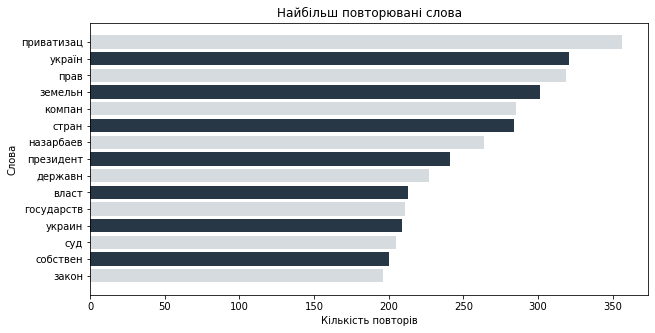

In [25]:
all_words_new = []

for i in range(train_df.shape[0]):
    sentence_example = train_df.iloc[i]['Текст']
    text = tokenize(sentence_example)
    for word in text:
        all_words_new.append(word)
counter = collections.Counter(all_words_new)
words = counter.most_common(15)
word = list()
number = list()
for i in words[::-1]:
    word.append(i[0])
    number.append(i[1])
print(word)
print(number)
fig = plt.figure(figsize=(10, 5))

colors = ['#D6DBDF', '#273746']
plt.barh(word, number, color=colors, left=0)

plt.xlabel('Кількість повторів')
plt.ylabel('Слова')
plt.title('Найбільш повторювані слова')
plt.show()

['підприємств', 'змін', 'суд', 'власност', 'податков', 'фонд', 'приватизаці', 'майн', 'земл', 'податк', 'прав', 'ділянк', 'державн', 'земельн', 'україн']
[74, 76, 77, 83, 84, 91, 105, 113, 116, 124, 159, 193, 224, 281, 318]


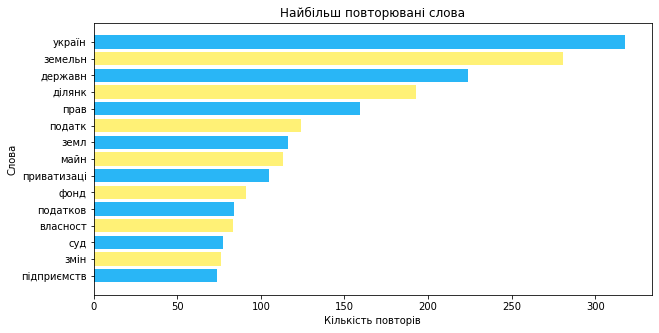

In [26]:
all_words_ukr = []

for i in range(ukr_df.shape[0]):
    sentence_example = ukr_df.iloc[i]['Текст']
    text = tokenize(sentence_example)
    for word in text:
        all_words_ukr.append(word)
counter = collections.Counter(all_words_ukr)
words = counter.most_common(15)
word = list()
number = list()
for i in words[::-1]:
    word.append(i[0])
    number.append(i[1])
print(word)
print(number)
fig = plt.figure(figsize=(10, 5))
colors = ['#29B6F6', '#FFF176']
plt.barh(word, number, color=colors, left=0)

plt.xlabel('Кількість повторів')
plt.ylabel('Слова')
plt.title('Найбільш повторювані слова')
plt.show()

['казахстанск', 'явля', 'доллар', 'росс', 'государствен', 'великобритан', 'президент', 'собствен', 'украин', 'государств', 'власт', 'назарбаев', 'компан', 'приватизац', 'стран']
[164, 170, 181, 184, 190, 190, 198, 200, 206, 210, 211, 264, 268, 283, 284]


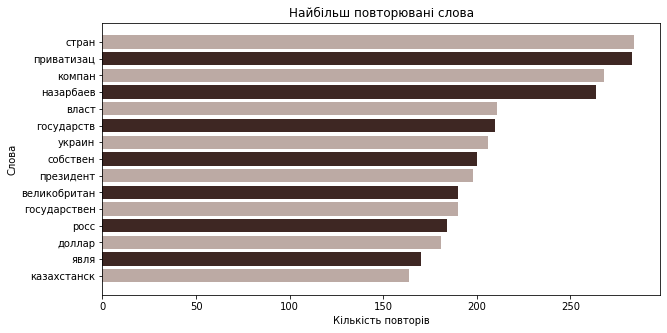

In [27]:
all_words_rus = []

for i in range(rus_df.shape[0]):
    sentence_example = rus_df.iloc[i]['Текст']
    text = tokenize(sentence_example)
    for word in text:
        all_words_rus.append(word)
counter = collections.Counter(all_words_rus)
words = counter.most_common(15)
word = list()
number = list()
for i in words[::-1]:
    word.append(i[0])
    number.append(i[1])
print(word)
print(number)
fig = plt.figure(figsize=(10, 5))

colors = ['#BCAAA4', '#3E2723']
plt.barh(word, number, color=colors, left=0)

plt.xlabel('Кількість повторів')
plt.ylabel('Слова')
plt.title('Найбільш повторювані слова')
plt.show()

<AxesSubplot:>

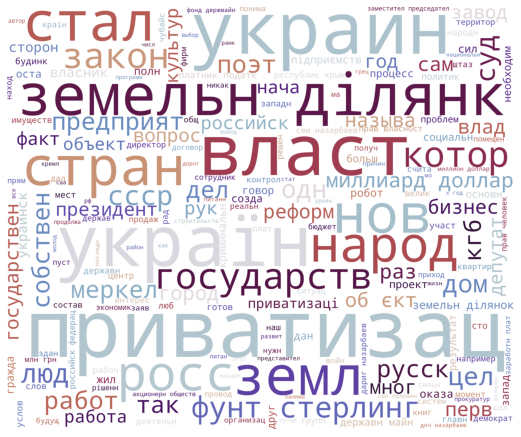

In [28]:
#Створення списку усіх слів
all_words = []
for i in range(train_df.shape[0]):
    sentence_example = train_df.iloc[i]['Текст']
    text = tokenize(sentence_example)
    for word in text:
        all_words.append(word)
# Отримаємо текстову строку зі списку
def str_corpus(corpus):
    str_corpus = ''
    for i in corpus:
        str_corpus += ' ' + i
    str_corpus = str_corpus.strip()
    return str_corpus
# Створення хмари слів
def get_wordCloud(corpus):
    wordCloud = WordCloud(background_color='white',
                              colormap='twilight',
                              stopwords=STOPWORDS,
                              width=3000,
                              height=2500,
                              max_words=200,
                              random_state=42
                         ).generate(str_corpus(corpus))
    return wordCloud

procWordCloud = get_wordCloud(all_words)

fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1)